In [41]:
#########################################################################################################################
#						Written by: Yih Kai Teh																			#
#																														#
#	This project is from one of my modules (Advanced Topic in Machine Learning) at UCL taught by Google DeepMind		#
#																														#
#						Edited by: Francesco Stranieri																	#
#																														#
#########################################################################################################################

In [42]:
import gym
import tensorflow as tf
from tensorflow.contrib.layers import convolution2d, fully_connected

import random
import numpy as np
from collections import deque
import os
#import pathlib

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.color import rgb2gray

#import cv2

In [43]:
game = "MsPacman"
version = "-v4"

In [44]:
env = gym.make(game+version)						# atari games selection

In [45]:
max_score = 0										# initialized the best score of the game as 0 (for saving model with best score)
n_steps = 1000000 / 8									# train for 1 millions steps (can increase for more if have better GPU)	ADDED /2
batch_size = 64										# mini batch size used for optimization
discount_rate = 0.99								# discount rate (control the value of reward for near future or distant future)
test_episode = int(100/2)								# number of test episodes to run for evaluation as each episode is stostatic	ADDED /2

replay_memory_size = n_steps / 2					# size of the Experience Replay to store the previous episodes 
replay_memory = deque()								# store of the details of episodes in Experience Replay

input_height = input_width = 28						# size of the reduced image height and width 
input_channels = 4									# the number of frame to stack together in order to capture the motion

conv_kernel_output_channel = [16, 32]				# output channel of kernel/filter for CNN
conv_kernel_sizes = [(6,6), (4,4)]					# size of the kernel/filter for CNN
conv_strides = [2, 2]								# number of strides for the kernel/filter to slide across image
conv_paddings = ["SAME"] * 2						# padding choice 
conv_activation = [tf.nn.relu] * 2					# activation for CNN (RELU is used here)

n_hidden_inputs = input_height * input_width * 2	# size of the flatten layer
n_hidden = 256										# number of hidden layer
n_outputs = env.action_space.n						# number of possible output for the game (this is different for each game)

In [46]:
initializer = tf.random_normal_initializer(seed=400, stddev=0.01)						# initializer for weight
b_initializer = tf.constant_initializer(0.1)											# initializer for bias
learning_rate =0.0001																	# learning rate for the optimizater 																			
Total_Clip_Return = Total_Discounted_Return = Total_Loss = Total_Episode = np.array([])	# store the details of loss and return throughout the process for plotting the graph
cummulative_loss = np.array([])															# store the cummulative loss for every 50k steps to monitor the loss 

In [47]:
# Create directory if it not exist
def check_directory(directory):
	#pathlib.Path(directory).mkdir(exist_ok=True) 
	if not os.path.exists(directory):
		os.makedirs(directory)

directory_game = './'+game
check_directory(directory_game)

In [48]:
# Q network architecture (conv(6x6x16) -> RELU -> conv(4x4x32) -> RELU -> flatten -> hidden layer (256 units) -> RELU -> output layer(number of actions))
def q_network(X_state, scope):
	prev_layer = X_state
	with tf.variable_scope(scope) as scope:
		for n_maps, kernel_size, stride, padding, activation in zip(conv_kernel_output_channel, conv_kernel_sizes, conv_strides, conv_paddings, conv_activation):
			prev_layer = convolution2d(prev_layer, num_outputs=n_maps, kernel_size=kernel_size, stride=stride, padding=padding, activation_fn=activation, weights_initializer=initializer, biases_initializer=b_initializer)
		last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_inputs])
		hidden = fully_connected(last_conv_layer_flat, n_hidden, activation_fn=tf.nn.relu, weights_initializer=initializer, biases_initializer=b_initializer)
		outputs = fully_connected(hidden, n_outputs, activation_fn=None, weights_initializer=initializer, biases_initializer=b_initializer)
	trainable_vars = {var.name[len(scope.name):]: var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)}
	return outputs, trainable_vars

In [49]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])	# placeholder for the state
target_Q_value, stationary_target_vars = q_network(X_state, scope="target_q_networks")			# the Q value from the stationary network
Q_value, current_target_vars = q_network(X_state, scope="q_networks")							# the Q value from the current network

# copy operation to update the stationary network by copying over from current network every 5k steps
copy = [stationary_target_var.assign(current_target_vars[var_name]) for var_name, stationary_target_var in stationary_target_vars.items()]
update_stationary_target = tf.group(*copy)

In [50]:
# Huber loss uses MSE for low values and MAE for large values
def huber_loss(y_true, y_pred):
        return tf.losses.huber_loss(y_true, y_pred)

with tf.variable_scope("train"):
	X_action = tf.placeholder(tf.int32, shape=[None])										# placeholder for the action
	y = tf.placeholder(tf.float32, shape=[None])											# placeholder for the true Q value
	qvalue = tf.reduce_sum(tf.multiply(Q_value, tf.one_hot(X_action, n_outputs)), axis=1)	# calculate the Q value
	#cost = tf.reduce_mean(tf.square(y - qvalue))											# define the cost function (differences between the true and estimated Q value)
	cost = tf.reduce_mean(huber_loss(y, qvalue))
	optimizer = tf.train.AdamOptimizer(learning_rate)										# optimizer used is ADAM, can be changed for other e.g. SGD
	training_op = optimizer.minimize(cost)													# minimize the cost function

In [51]:
# Randomly sample the mini batch of previous episdoes from experience replay for training
def sample_memories(batch_size):
	indices = np.random.permutation(len(replay_memory))[:batch_size]
	cols = [[], [], [], [], []] 										# state, action, reward, next_state, continue
	for idx in indices:
		memory = replay_memory[idx]
		for col, value in zip(cols, memory):
			col.append(value)
	cols = [np.array(col) for col in cols]
	return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [52]:
# epsilon greedy with fix epsilon. Ideally, a decay epsilon is required to reach optimal policy. But it is difficult pick the decay rate.
def epsilon_greedy(q_values):
	if float(np.random.rand(1)) < 0.1:
		return env.action_space.sample() 	# random action
	else:
		return np.argmax(q_values) 			# optimal action

In [53]:
# preprocess observation to convert RGB into greyscale, remove some extra useless blank on the side, and resize. (Mainly to speed up computation and improve performance)
def preprocess_observation(obs):
	img = resize(rgb2gray(obs[:, :, :]), (input_height, input_width), mode='constant')
	#cv2.namedWindow('image', cv2.WINDOW_NORMAL)
	#cv2.imshow('image',img)
	#cv2.waitKey(0)
	#cv2.destroyAllWindows()
	img = np.reshape(img, [input_height, input_width, 1])
	return img

In [54]:
# Build up the initial 4 frames in each eipsodes
def initial_4_frames():
	for t in range(input_channels):
		if t == 0:								# for the first frame
			obs = env.reset()
			img = preprocess_observation(obs)
			state = img
		else:									# for the next 3 frames
			obs, _, _, _ = env.step(0)
			img = preprocess_observation(obs)
			state = np.dstack((state, img))
	return state

In [55]:
# run the evaluation at every 50k steps in order to monitor the performance during training 
def evaluation(iteration, cummulative_loss):
	global Total_Clip_Return, Total_Discounted_Return, Total_Loss, Total_Episode

	# Reset all the return (real, discounted, clipped) to 0 for each time the evaluation is run
	real_return = clip_return = discounted_return = 0

	# run the evaluation for 100 episodes and take the average because each episodes is stochastics
	for e in range(test_episode):
		print("\rTest: {} ".format(e), end="")

		# Build up the initial 4 frames of observation
		evaluation_state = initial_4_frames()

		# reset the superscript of reward in each episodes 
		superscript = 0
		ndone = True

		while ndone:
			# select action based on the maximum value of action-value function (Q function)
			selected_action = np.argmax(Q_value.eval(feed_dict={X_state: [evaluation_state]})[0])

			# Step through the environment with the selected action
			obs, reward, done, _ = env.step(selected_action)

			# Store the previous observation for later calculation and update the 4 frames with the latest observation
			old_obs = evaluation_state
			next_state = preprocess_observation(obs)
			evaluation_state = np.delete(evaluation_state, [0], axis=2)
			evaluation_state = np.dstack((evaluation_state, next_state))

			# Evaluate the real, clip and discounted rewards
			real_return +=  reward
			reward = np.clip(reward, -1, 1)
			clip_return += reward
			discounted_return += (discount_rate ** (superscript)) * reward

			# increase the superscript of the reward in each timestep 
			superscript += 1

			if done:
				ndone = False

	# calculate all the average rewards (real, clip and discounted) over 100 episodes as the indicators of the performance
	average_real_return = real_return/test_episode
	average_clip_return = clip_return/test_episode
	average_discounted_return = discounted_return/test_episode

	# Display and store all the result for plotting the graph at the end of training
	print ('Steps: %4d Mean Real Return: %10f Mean Clip Return: %10f Mean Discounted Return: %10f Training Loss : %f' %(iteration + 1, average_real_return, average_clip_return, average_discounted_return, np.mean(cummulative_loss)))
	Total_Clip_Return = np.append(Total_Clip_Return, average_clip_return)
	Total_Discounted_Return = np.append(Total_Discounted_Return, average_discounted_return)
	Total_Loss = np.append(Total_Loss, np.mean(cummulative_loss))
	Total_Episode = np.append(Total_Episode, iteration + 1)
	return average_clip_return

In [56]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
	init.run()
	saver = tf.train.Saver()
	iteration = 0
	run_evaluation = False
	done = True

	# Copy from real network into stationary network to ensure both have the same initial weight and bias
	update_stationary_target.run()

	while True:
		print("\rIteration {}".format(iteration), end="")
		iteration += 1

		# Break the loop when it hit maximum 1 million steps and run one last evaluation
		if iteration >= n_steps and done:
			average_clip_return = evaluation(iteration, cummulative_loss)
			cummulative_loss = np.array([])

			directory_final = './'+game+'/model_Final_'+game
			check_directory(directory_final)

			# Store the final model
			saver.save(sess, directory_final+'/'+game)
			break   									# TO REMOVE

		# Update the stationary target by copying the current network to the stationary network every 5k steps
		if (iteration + 1) % 5000 == 0:
			update_stationary_target.run()

		# Run the evaluation every 50k steps and one time at the first 1k step just to evaluate the performance before training
		if (iteration + 1) % (n_steps / 5) == 0 or iteration == 1000:
			run_evaluation = True

		if done: 
			# Run the evaluation every 50k steps
			if run_evaluation == True:
				average_clip_return = evaluation(iteration, cummulative_loss)
				cummulative_loss = np.array([])

				directory_checkpoint = directory_game+'/model_'+game
				#print(directory_checkpoint)
				check_directory(directory_checkpoint)

				# Store the Best Model 
				if average_clip_return > max_score:
					saver.save(sess, directory_checkpoint+'/'+game)
					max_score = average_clip_return

				run_evaluation = False

			# Build up the initial 4 frames of observation
			state = initial_4_frames()

		# Evaluate the Q Value to select action
		q_values = Q_value.eval(feed_dict={X_state: [state]})
		action = epsilon_greedy(q_values)

		# Step through the environment with the selected action and preprocess the observation into 60 x 60
		obs, reward, done, info = env.step(action)
		next_state = preprocess_observation(obs)

		# Store the previous observation for later calculation and update the 4 frames with the latest observation
		old_state = state
		state = np.delete(state, [0], axis=2)
		state = np.dstack((state, next_state))

		# clip the reward (for more stable gradient update) and append all the information into experience replay 
		clipped_reward = np.clip(reward, -1, 1)
		replay_memory.append((old_state, action, clipped_reward, state, 1.0 - done))

		# clear the experience replay by one to allow for new memory (This only start after experience replay has stored over 1 millions episodes)
		if len(replay_memory) > replay_memory_size:
			replay_memory.popleft()

		# Start Training once the experience replay has enough for one batch size
		if len(replay_memory) > batch_size:
			X_state_val, X_action_val, rewards, X_next_state_val, continues = sample_memories(batch_size)
			next_q_values = target_Q_value.eval(feed_dict={X_state: X_next_state_val})
			y_val = rewards + discount_rate * continues * np.max(next_q_values, axis=1, keepdims=True)
			y_val = np.reshape(y_val, (64))
			loss, _ = sess.run([cost, training_op], feed_dict={X_state: X_state_val, X_action: X_action_val, y: y_val})
			cummulative_loss = np.append(cummulative_loss, loss)

Iteration 47

D:\fra_v\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Test: 49  1561Steps: 1563 Mean Real Return: 167.400000 Mean Clip Return:  16.740000 Mean Discounted Return:   2.825452 Training Loss : 0.031492
Test: 49  25483Steps: 25485 Mean Real Return: 578.000000 Mean Clip Return:  42.120000 Mean Discounted Return:   5.244785 Training Loss : 0.018852
Test: 49  50655Steps: 50657 Mean Real Return: 547.400000 Mean Clip Return:  43.520000 Mean Discounted Return:   4.835790 Training Loss : 0.017451
Test: 49  75334Steps: 75336 Mean Real Return: 586.200000 Mean Clip Return:  42.140000 Mean Discounted Return:   4.732728 Training Loss : 0.023712
Test: 49  100855Steps: 100857 Mean Real Return: 651.600000 Mean Clip Return:  45.080000 Mean Discounted Return:   5.109529 Training Loss : 0.029477
Test: 49  125127Steps: 125129 Mean Real Return: 720.200000 Mean Clip Return:  46.980000 Mean Discounted Return:   5.364996 Training Loss : 0.034448


In [64]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plot for the graph for the clip return, discounted return and loss throughout the training
directory_figure = directory_game+'/Graphs_and_Figure'
check_directory(directory_figure)

Populating the interactive namespace from numpy and matplotlib


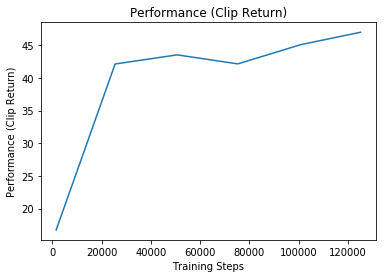

In [67]:
plt.figure(1)
plt.plot(Total_Episode, Total_Clip_Return)
plt.title('Performance (Clip Return)')
plt.xlabel('Training Steps')
plt.ylabel('Performance (Clip Return)')
plt.savefig(directory_figure+'/Plot of Performance (Clip Return) Over '+str(n_steps)+' Steps.png')
plt.show()

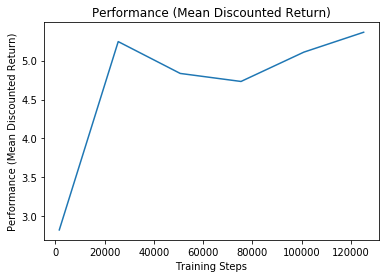

In [68]:
plt.figure(2)
plt.plot(Total_Episode, Total_Discounted_Return)
plt.title('Performance (Mean Discounted Return)')
plt.xlabel('Training Steps')
plt.ylabel('Performance (Mean Discounted Return)')
plt.savefig(directory_figure+'/Plot of Performance Over '+str(n_steps)+' Steps.png')
plt.show()

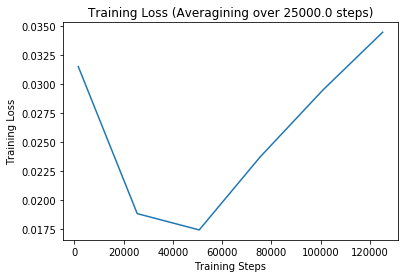

In [70]:
plt.figure(3)
plt.plot(Total_Episode, Total_Loss)
plt.title('Training Loss (Averagining over '+str(n_steps/5)+' steps)')
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.savefig(directory_figure+'/Plot of Loss Over '+str(n_steps)+' Steps.png')
plt.show()